In [5]:
import numpy as np
import skimage as sk
import skimage.io as skio
import glob
from skimage.transform import resize
import torch

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils


import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import random

In [6]:
def get_noses():
    """
    Face data are X
    Nose points are y
    """
    asf_files = glob.glob("imm_face_db/*.asf")
    img_files = [s[:-3] + 'jpg' for s in asf_files]
    
    noses = []

    for asf in asf_files:
        file = open(asf)
        
        points = file.readlines()[16:74]
        landmark = []

        for point in points:
            x,y = point.split('\t')[2:4]
            landmark.append([float(x), float(y)])

        # the nose keypoint
        noses.append(np.array(landmark).astype('float32')[-6])
        
    noses = np.array(noses)

    faces = []

    for img_name in img_files:
        img = skio.imread(img_name)
        img = (img.astype(np.float32) / 255 - 0.5)
        img = resize(img, (60,80), anti_aliasing=True)
        img = np.mean(img, axis = 2)
        faces.append(img)
        
    faces = np.array(faces)
    
    return faces, noses
    

In [7]:
class NosesDataset(Dataset):
    """Wrapper for Nose Dataset"""

    def __init__(self,X, y, transform=None):
        
        assert len(X) == len(y)
                       
        self.faces = torch.Tensor(X).unsqueeze(1)  
        self.noses = torch.Tensor(y)
        self.transform = transform
        
    def __len__(self):
        return len(self.noses)

    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        image_nose_map = {'image': self.faces[idx], 'nose': self.noses[idx]}

        if self.transform:
            image_nose_map = self.transform(image_nose_map)

        return image_nose_map

In [8]:
X_all, y_all = get_noses()

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_all, y_all, test_size=48, random_state=None, shuffle = False)

In [10]:
train_dataset = NosesDataset(X_train, y_train)
val_dataset = NosesDataset(X_val, y_val)

In [33]:
train_dataset[0]['image'].shape

torch.Size([1, 60, 80])

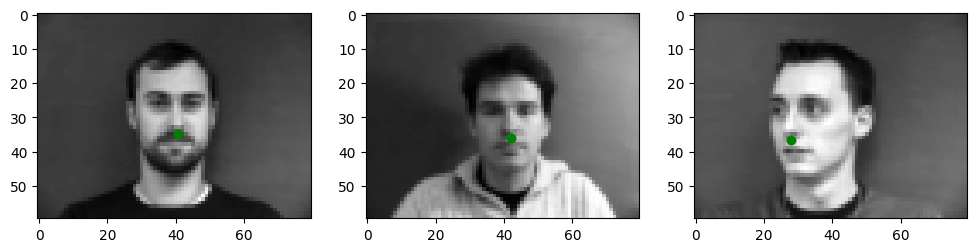

In [53]:
fig = plt.figure(figsize=(12, 6))
axes = fig.subplots(1, 3)

axes[0].imshow(train_dataset[30]['image'][0], cmap="gray")
axes[0].scatter(train_dataset[30]['nose'][0] * 80, train_dataset[30]['nose'][1] * 60, color='green')

axes[1].imshow(train_dataset[40]['image'][0], cmap="gray")
axes[1].scatter(train_dataset[40]['nose'][0] * 80, train_dataset[40]['nose'][1] * 60, color='green')
axes[2].imshow(train_dataset[50]['image'][0], cmap="gray")
axes[2].scatter(train_dataset[50]['nose'][0] * 80, train_dataset[50]['nose'][1] * 60, color='green')

plt.savefig("Nose_truths_dataloader.jpg")


# Neural Net

In [12]:
class NoseNet(nn.Module):
    def __init__(self):
        super(NoseNet, self).__init__()
        # 1 input image channel, 12 output channels, 5x5 square convolution
        
        # kernel
        self.conv1 = nn.Conv2d(1, 12, 5)
        self.conv2 = nn.Conv2d(12, 12, 5)
        self.conv3 = nn.Conv2d(12, 12, 5)
        
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(288, 100)  # 5*5 from image dimension
        self.fc2 = nn.Linear(100, 2)
        
    
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cpu device


In [14]:
model = NoseNet().to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print(model)

NoseNet(
  (conv1): Conv2d(1, 12, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(12, 12, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(12, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=288, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)


# Training Data
https://pytorch.org/tutorials/beginner/introyt/trainingyt.html

In [15]:
BATCH_SIZE = 1
NUM_OF_EPOCHS = 25
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [16]:
def train(dataloader, model, loss_function, optimizer):
    size = len(dataloader.dataset)
    model.train()
    
    total_loss = 0
    
    for i, batch in enumerate(dataloader):
        image, nose = batch['image'], batch['nose']
        image, nose = image.to(device), nose.to(device)
        
        # Zero your gradients for every batch!
        model.zero_grad()
        # Make predictions for this batch
        output = model(image)
        loss = loss_function(output, nose)
        loss.backward()
        optimizer.step()
        
        total_loss += loss
        
    mean_loss = total_loss / (i + 1)
        
    return mean_loss

def validate(dataloader, model, loss_function, optimizer):
    size = len(dataloader.dataset)
    model.eval()
    
    total_loss = 0
    
    for i, batch in enumerate(dataloader):
        image, nose = batch['image'], batch['nose']
        image, nose = image.to(device), nose.to(device)
        
        # Zero your gradients for every batch!
        model.zero_grad()
        # Make predictions for this batch
        output = model(image)
        loss = loss_function(output, nose)
        
        total_loss += loss
        
    mean_loss = total_loss / (i + 1)
        
    return mean_loss

def predict(dataloader, model):
    outputs = []
    model.eval()
    
    for batch in dataloader:
        image = batch['image']
        image = image.to(device)
        
        output = model(image)

        output = output.cpu()
        outputs.append(output.detach().numpy())
    
    output_vector = np.stack(outputs, axis=0)
    return output_vector

In [17]:
train_losses = []
val_losses = []

for epoch in range(NUM_OF_EPOCHS):
    train_loss = train(train_loader, model, loss_function, optimizer)
    val_loss = validate(val_loader, model, loss_function, optimizer)
    
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())

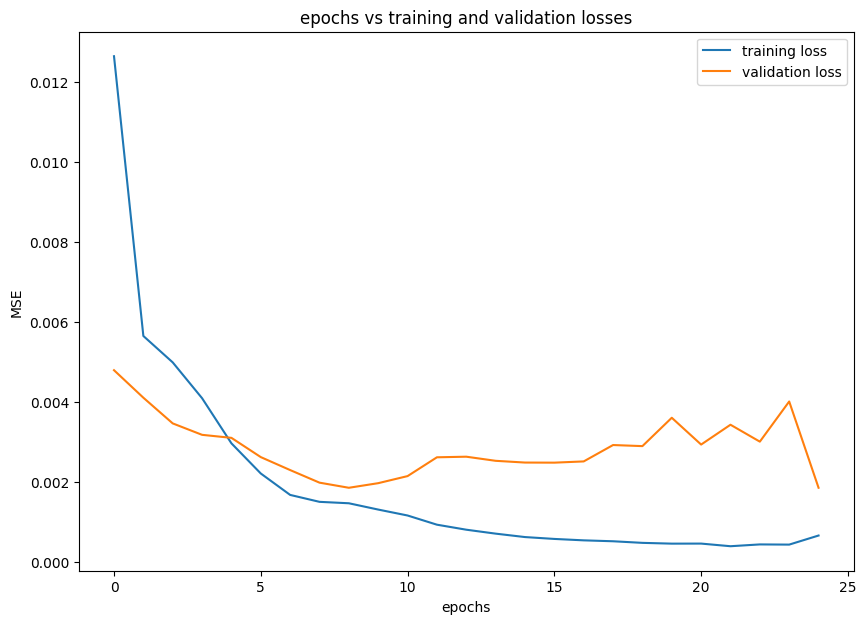

In [18]:
plt.figure(figsize = (10, 7))
plt.plot(range(len(train_losses)), train_losses, label = 'training loss')
plt.plot(range(len(val_losses)), val_losses, label = 'validation loss')
plt.ylabel('MSE')
plt.xlabel('epochs')
plt.title('epochs vs training and validation losses')
plt.legend()
plt.savefig("epoch_vs_training_noses.jpg")

In [19]:
predictions = predict(val_loader, model)
predictions = predictions.reshape((predictions.shape[0], predictions.shape[-1]))

In [20]:
rankings = list(np.arange(len(predictions)))
rankings.sort(key=lambda i: sum((predictions[i] - y_val[i])**2))

In [21]:
def show_image_and_points(ax, image_idx):  
    ax.imshow(X_val[image_idx], cmap='Greys_r')
    pred_point = predictions[image_idx] * np.array([80, 60])
    ground_truth_point = y_val[image_idx] * np.array([80, 60])
    
    ax.set_title(f"Validation Set Number {image_idx}")
    ax.scatter(ground_truth_point[0], ground_truth_point[1], color='green', label='ground truth')
    ax.scatter(pred_point[0], pred_point[1], marker='x', color='red', label = 'prediction')
    ax.legend()

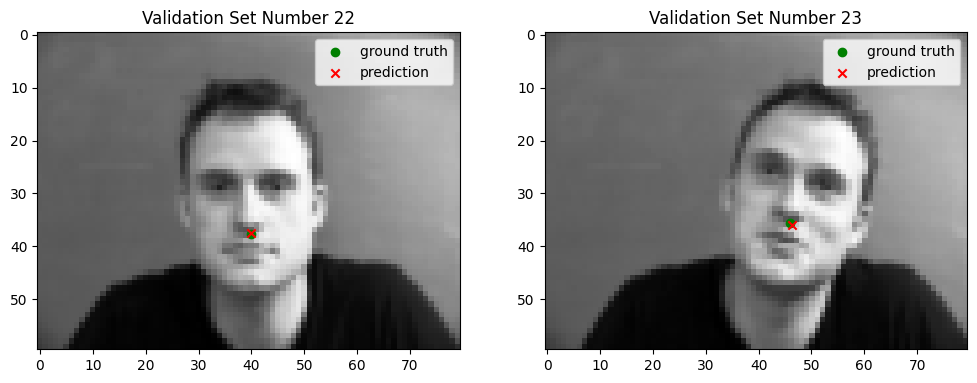

In [22]:
fig = plt.figure(figsize=(12, 6))
axes = fig.subplots(1, 2)
for ax, idx in list(zip(axes, rankings[:2])):
    show_image_and_points(ax, idx)
plt.savefig("best_nose_detection.jpg")

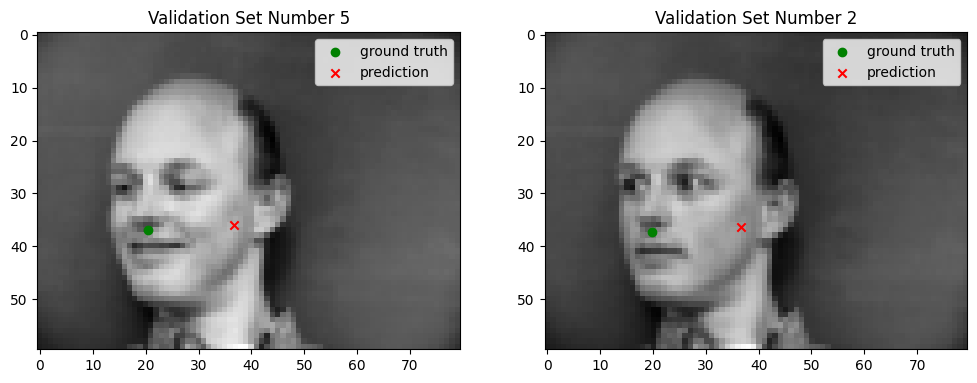

In [23]:
fig = plt.figure(figsize=(12, 6))
axes = fig.subplots(1, 2)
for ax, idx in list(zip(axes, rankings[-2:])):
    show_image_and_points(ax, idx)
plt.savefig("worst_nose_detection.jpg")

# Visualizing Filters

In [24]:
def display_grid_of_images(array_of_images, array_of_names, w = 6, h = 5):
    num_rows = len(array_of_images)
    num_cols = len(array_of_images[0])
  
    fig = plt.figure(figsize=(w * num_cols, h * num_rows))
    subplots = fig.subplots(num_rows, num_cols, squeeze = False)
    
    for row in range(num_rows):
        for col in range(num_cols):
            
            ax = subplots[row, col]
            ax.set_title(array_of_names[row][col])
            pixels = array_of_images[row][col]
            
            if len(pixels.shape) == 2:
                ax.imshow(pixels,cmap='Greys_r')
            if len(pixels.shape) == 3:
                ax.imshow(pixels)
    return fig
                
def show_filters(weights):
    rows, cols = weights.shape[0], weights.shape[1]
    titles = [[f"in: {in_c}, out: {out_c}" for in_c in range(cols)] for out_c in range(rows)]
    
    return display_grid_of_images(weights, titles, w = 3, h = 3)

In [25]:
retrieve = lambda x: x.weight.cpu().detach().numpy()
conv1, conv2, conv3 = retrieve(model.conv1), retrieve(model.conv2), retrieve(model.conv3)

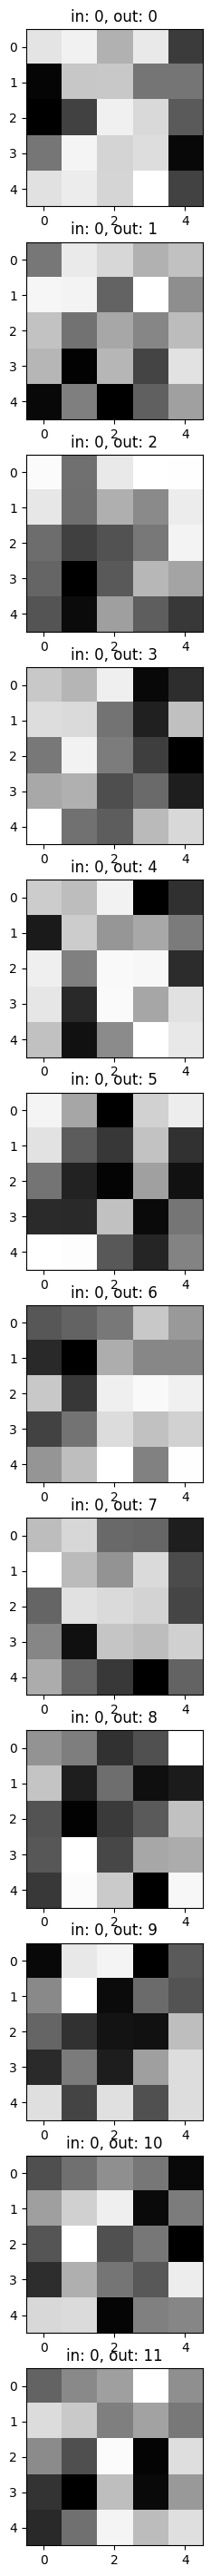

In [26]:
fig = show_filters(conv1)
fig.savefig("nose_conv1.jpg")

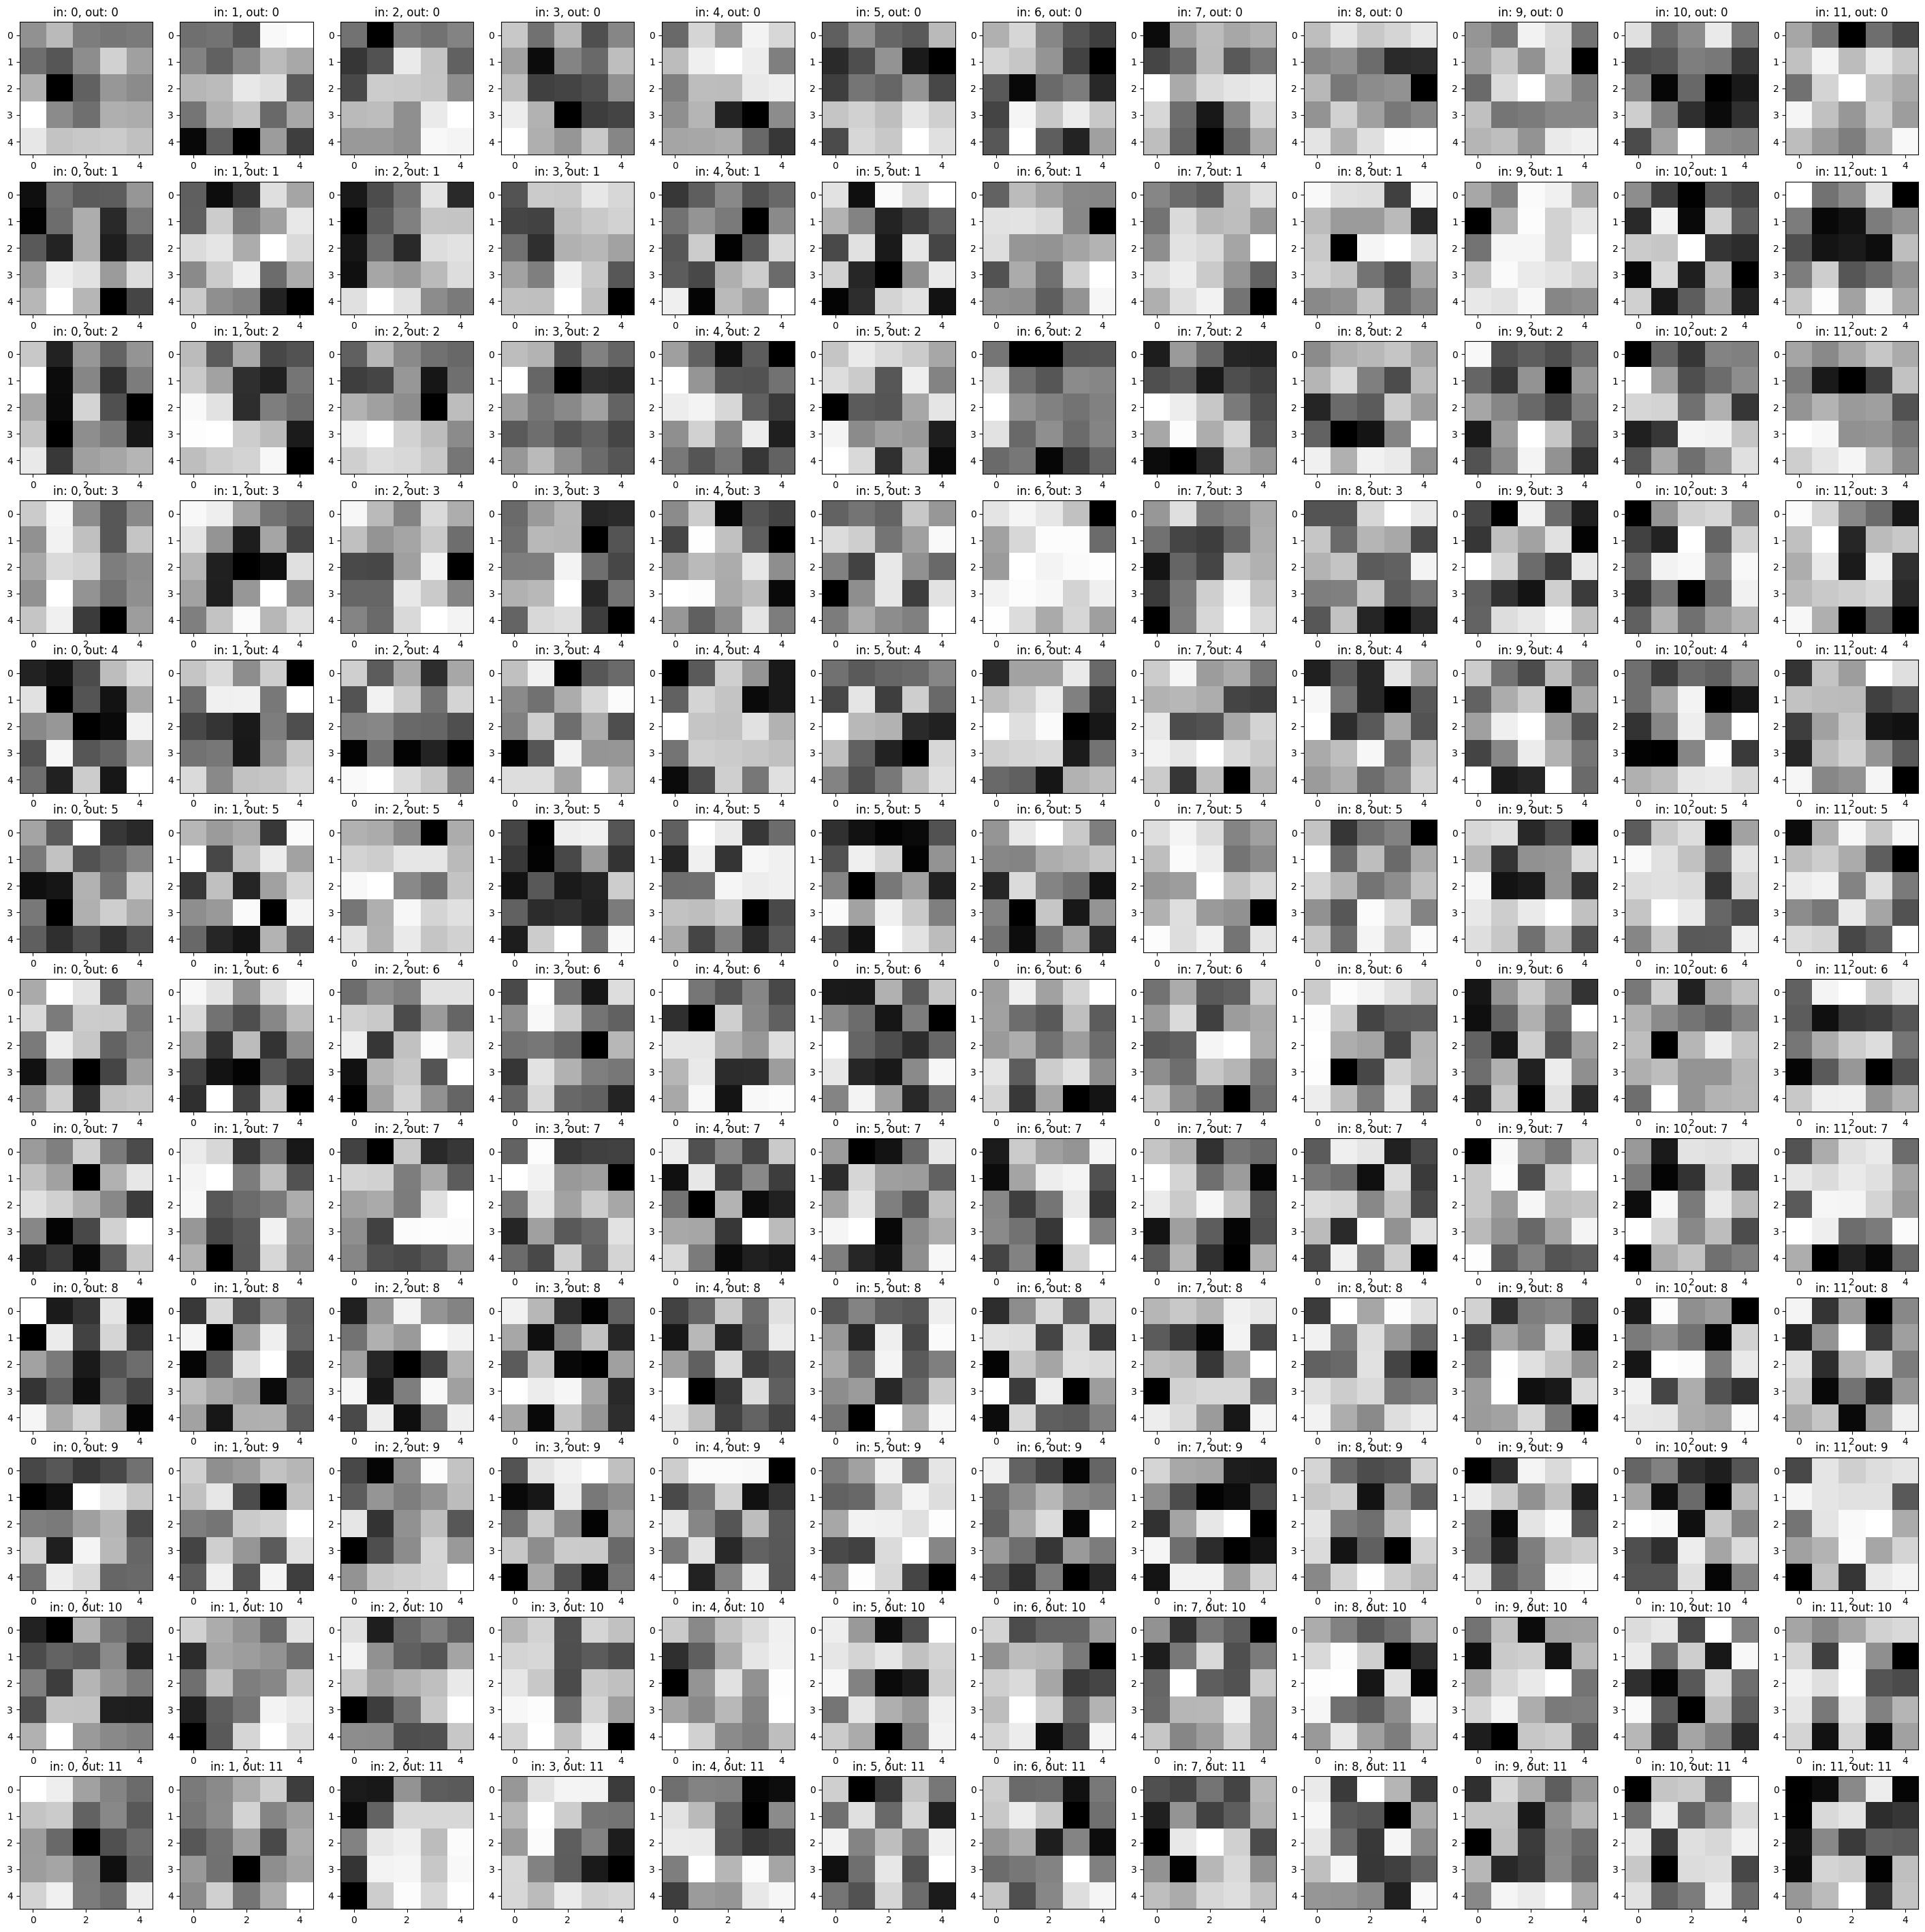

In [27]:
fig = show_filters(conv2)
fig.savefig("nose_conv2.jpg")

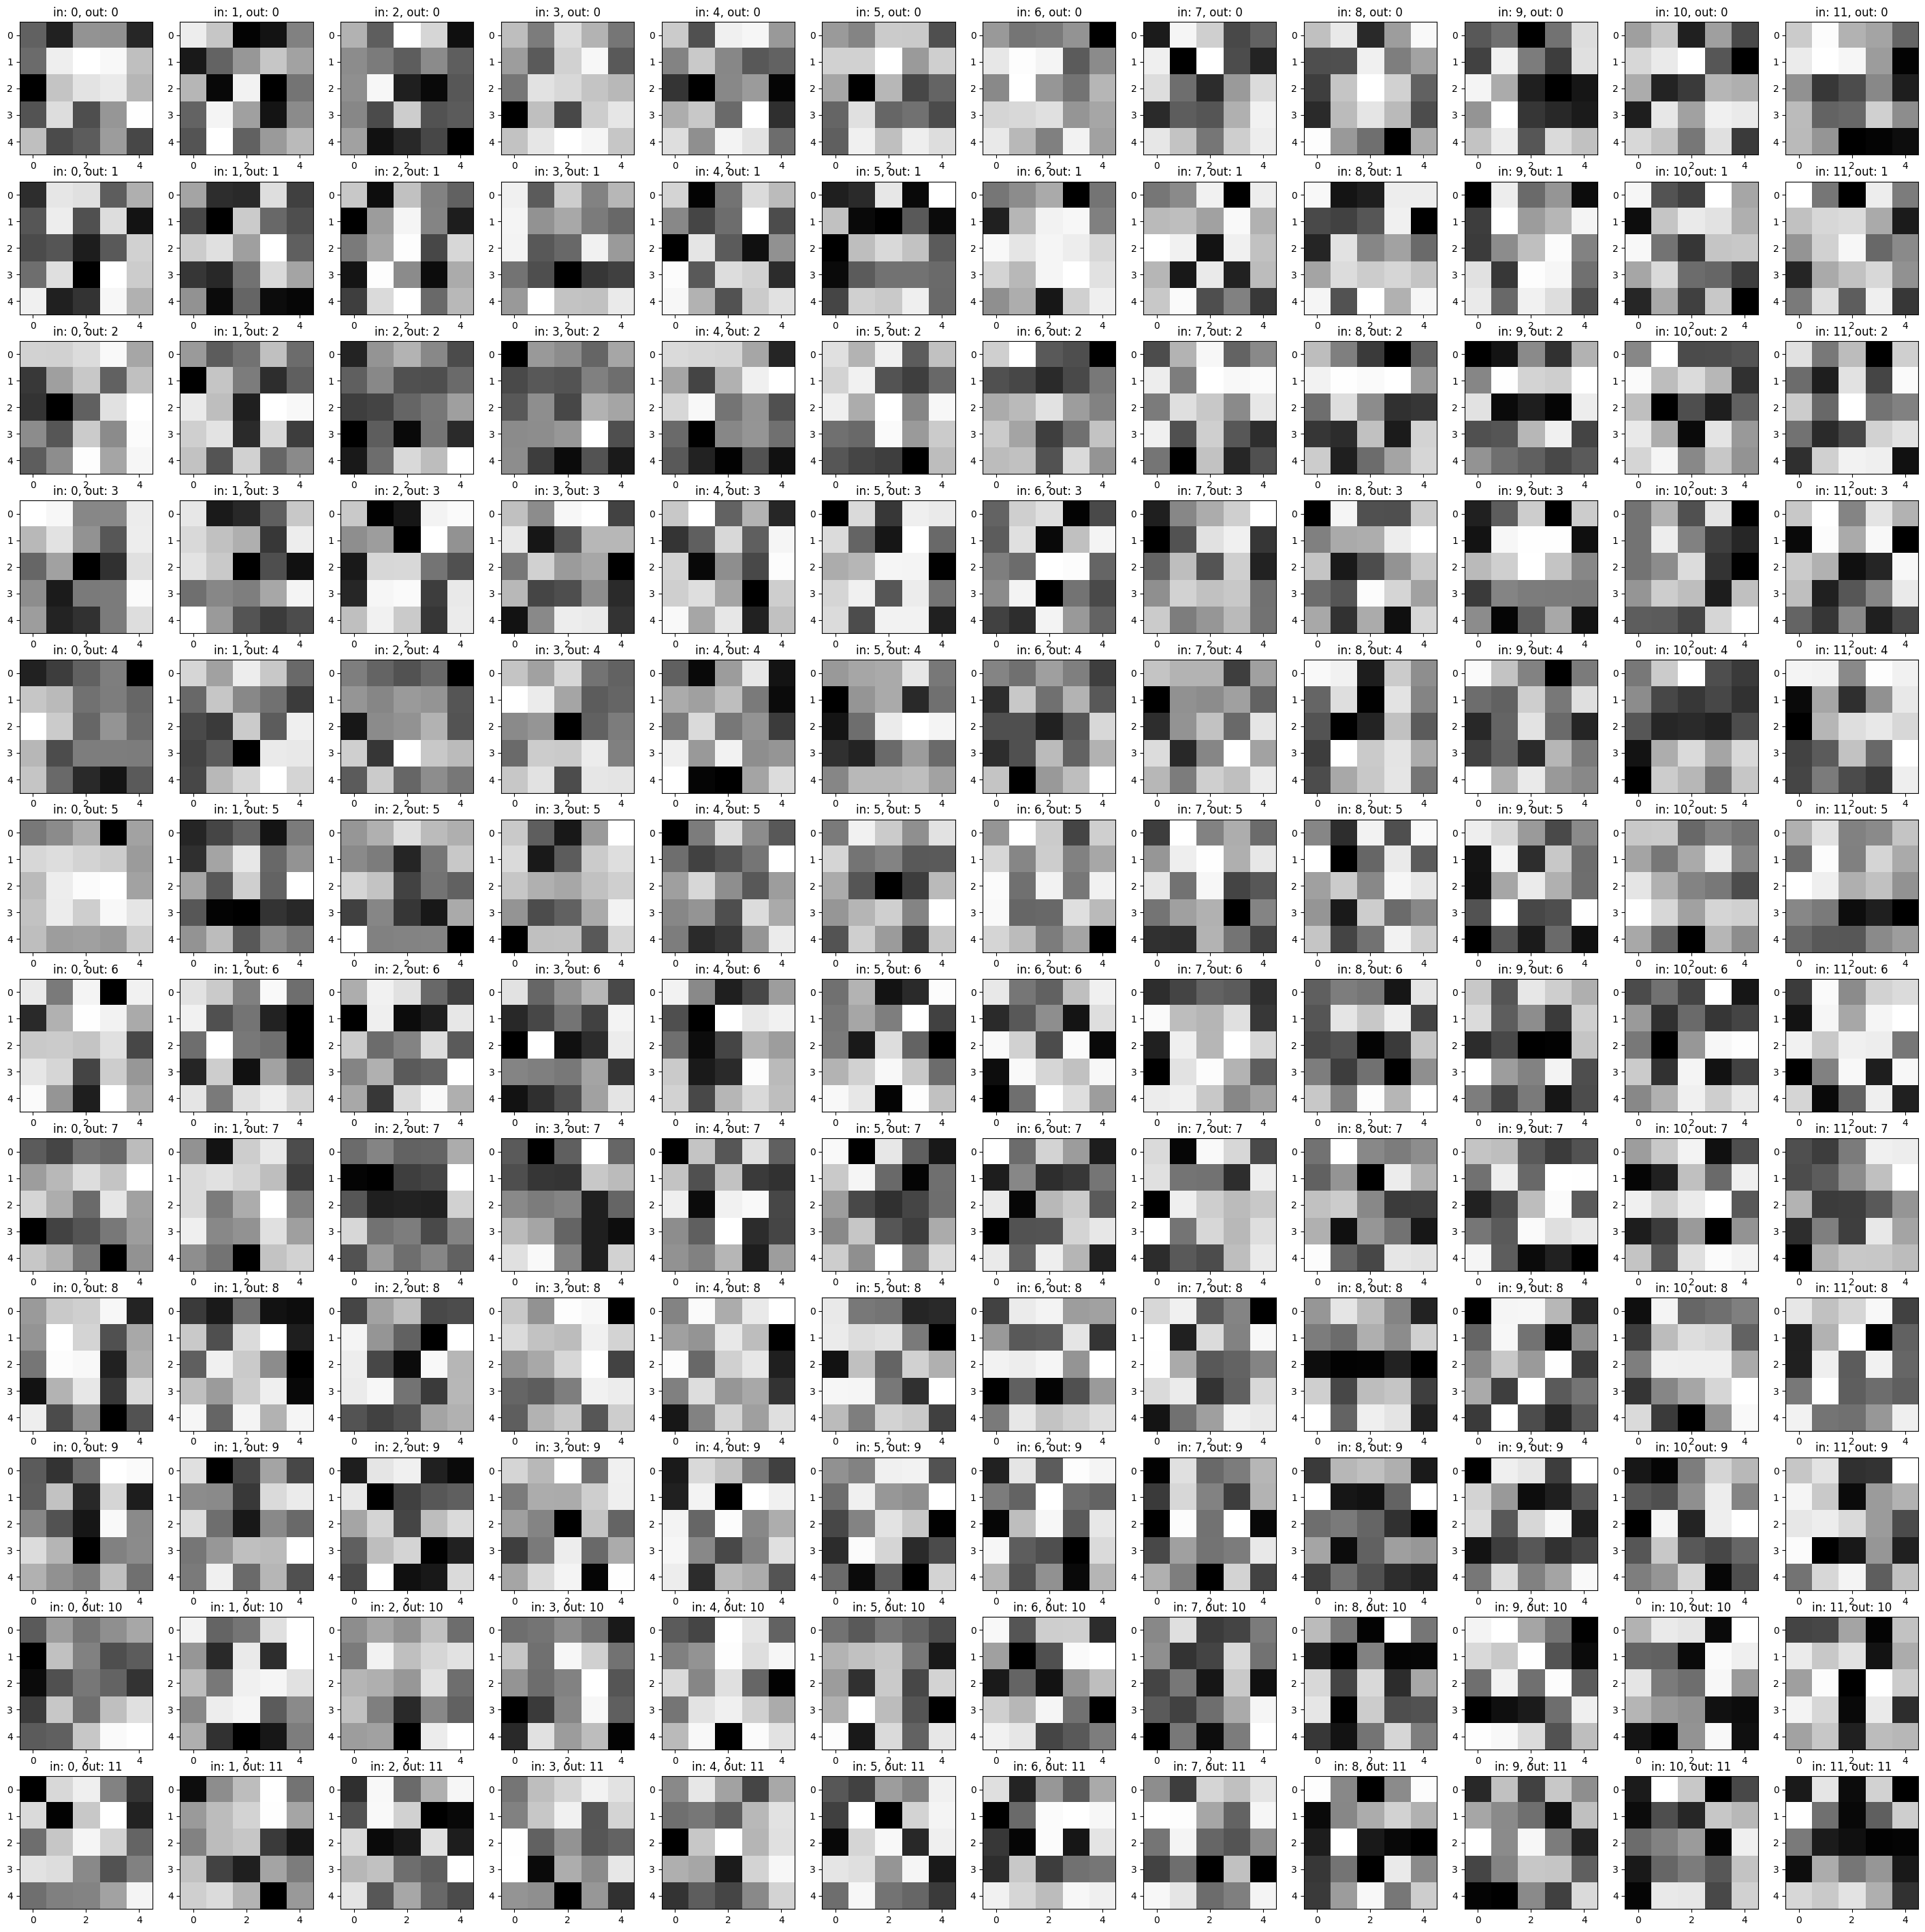

In [28]:
fig = show_filters(conv3)
fig.savefig("nose_conv3.jpg")